In [1]:
import os
import re
import sys,os
sys.path.append('/cluster/home/kamara/Explain/')

import torch
from torch_geometric.data import download_url


from gen_utils import check_dir
from dataset import extract_zip, extract_gz, process_mutag, collate_data

sys.path.append('/cluster/home/kamara/Explain/exp_synthetic')


import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import pandas.util.testing as tm

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph, from_scipy_sparse_matrix, to_scipy_sparse_matrix
from torch_geometric.utils import is_undirected, to_undirected
from scipy.sparse import csr_matrix

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax

from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv

import sys, os
sys.path.append('/cluster/home/kamara/Explain')

import json
import pickle
import time
from datetime import datetime
import argparse
import random
import itertools


from gen_utils import check_dir, get_subgraph, from_edge_index_to_adj, from_adj_to_edge_index
from parser_utils import arg_parse
from graph_utils import *
from math_utils import *


/cluster/apps/nss/gcc-6.3.0/python/3.7.4/x86_64/lib64/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
data_name = 'mutag'
data_save_dir = os.path.join('data', data_name)

check_dir(data_save_dir)
raw_data_dir = os.path.join(data_save_dir, 'raw_data')
# Save data_list
data_filename = os.path.join(data_save_dir, data_name) + '.pt'

#download MUTAG from url and put it in raw_dir
url = 'https://github.com/divelab/DIG_storage/raw/main/xgraph/datasets/MUTAG.zip'

path = download_url(url, raw_data_dir)
if url[-2:] == 'gz':
    extract_gz(path, raw_data_dir)
    os.unlink(path)
elif url[-3:] == 'zip':
    extract_zip(path, raw_data_dir)
    os.unlink(path)

data_list = process_mutag(raw_data_dir)
torch.save(collate_data(data_list), data_filename)


Extracting data/mutag/raw_data/MUTAG.zip


188


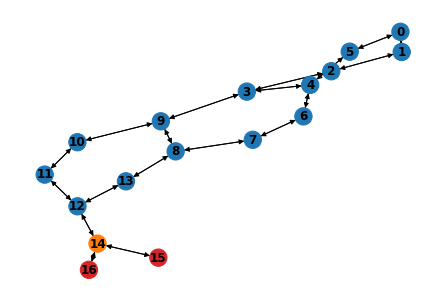

<Figure size 432x288 with 0 Axes>

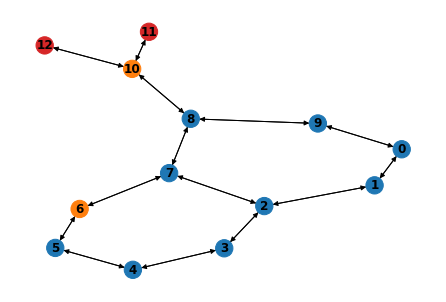

<Figure size 432x288 with 0 Axes>

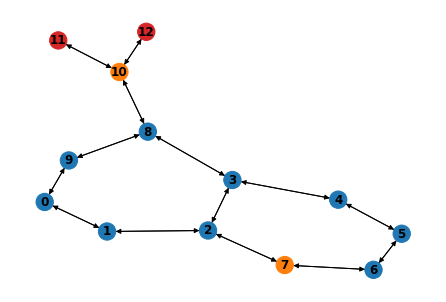

<Figure size 432x288 with 0 Axes>

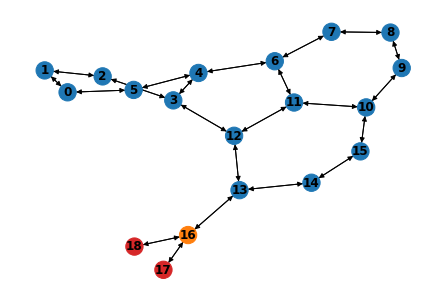

<Figure size 432x288 with 0 Axes>

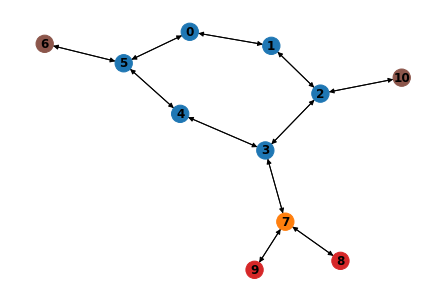

<Figure size 432x288 with 0 Axes>

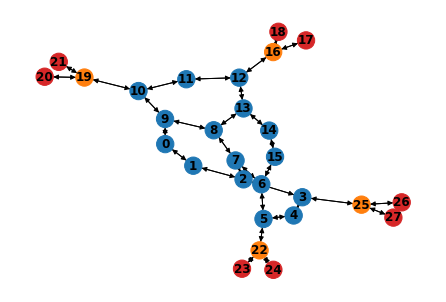

<Figure size 432x288 with 0 Axes>

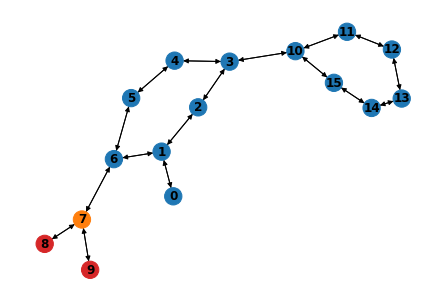

<Figure size 432x288 with 0 Axes>

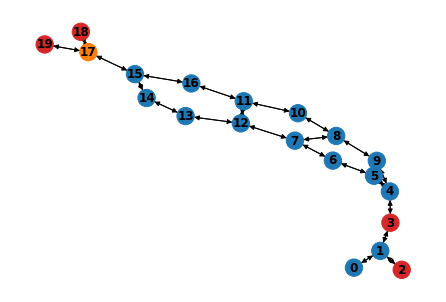

<Figure size 432x288 with 0 Axes>

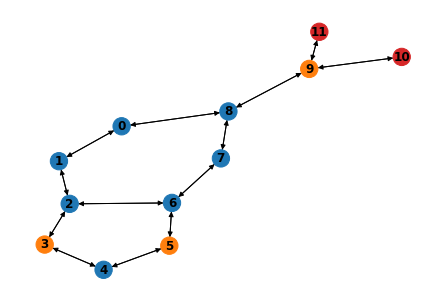

<Figure size 432x288 with 0 Axes>

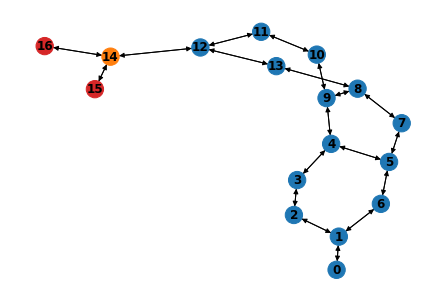

<Figure size 432x288 with 0 Axes>

In [3]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

n_graphs = len(data_list)
print(n_graphs)

for i in range(10):
    d = data_list[i]
    atoms = np.argmax(d.x, axis=1)
    g = to_networkx(d)
    
    plt.figure()
    nx.draw(g, cmap=plt.get_cmap('tab10'), node_color=atoms, with_labels=True, font_weight='bold', vmin =0, vmax=6)
    plt.show()
    plt.clf()


In [117]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F


# GCN basic operation
class GraphConv(nn.Module):
    def __init__(
            self,
            input_dim,
            output_dim,
            add_self=False,
            normalize_embedding=False,
            dropout=0.0,
            bias=True,
            gpu=True,
            att=False,
    ):
        super(GraphConv, self).__init__()
        self.gpu = gpu
        self.att = att
        self.add_self = add_self
        self.dropout = dropout
        if dropout > 0.001:
            self.dropout_layer = nn.Dropout(p=dropout)
        self.normalize_embedding = normalize_embedding
        self.input_dim = input_dim
        self.output_dim = output_dim
        if not gpu:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim)
                )
            if att:
                self.att_weight = nn.Parameter(torch.FloatTensor(input_dim, input_dim))
        else:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim).cuda())
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim).cuda()
                )
            if att:
                self.att_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, input_dim).cuda()
                )
        if bias:
            if not gpu:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim))
            else:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim).cuda())
        else:
            self.bias = None

        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, adj):
        if self.dropout > 0.001:
            x = self.dropout_layer(x)
        # deg = torch.sum(adj, -1, keepdim=True)
        if self.att:
            x_att = torch.matmul(x, self.att_weight)
            # import pdb
            # pdb.set_trace()
            att = x_att @ x_att.permute(0, 2, 1)
            # att = self.softmax(att)
            adj = adj * att
            
        if self.gpu:
            adj = adj.cuda()
            x = x.cuda()
            self.weight = nn.Parameter(self.weight.cuda())
            
        y = torch.matmul(adj, x)
        y = torch.matmul(y, self.weight)
        if self.add_self:
            self_emb = torch.matmul(x, self.self_weight)
            y += self_emb
        if self.bias is not None:
            y = y + self.bias
        # if self.normalize_embedding:
        # y = F.normalize(y, p=2, dim=2)
        # print(y[0][0])
        return y, adj


class GcnEncoderGraph(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dim,
            embedding_dim,
            label_dim,
            num_layers,
            pred_hidden_dims=[],
            concat=True,
            bn=True,
            dropout=0.0,
            add_self=False,
            args=None,
    ):
        super(GcnEncoderGraph, self).__init__()
        self.concat = concat
        add_self = add_self
        self.bn = bn
        self.num_layers = num_layers
        self.num_aggs = 1

        self.bias = True
        self.gpu = args.gpu
        if args.method == "att":
            self.att = True
        else:
            self.att = False
        # if args is not None:
        # self.bias = args.bias

        self.conv_first, self.conv_block, self.conv_last = self.build_conv_layers(
            input_dim,
            hidden_dim,
            embedding_dim,
            num_layers,
            add_self,
            normalize=True,
            dropout=dropout,
        )
        self.act = nn.ReLU()
        self.label_dim = label_dim

        if concat:
            self.pred_input_dim = hidden_dim * (num_layers - 1) + embedding_dim
        else:
            self.pred_input_dim = embedding_dim
        self.pred_model = self.build_pred_layers(
            self.pred_input_dim, pred_hidden_dims, label_dim, num_aggs=self.num_aggs
        )

        for m in self.modules():
            if isinstance(m, GraphConv):
                init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))
                if m.att:
                    init.xavier_uniform_(
                        m.att_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.add_self:
                    init.xavier_uniform_(
                        m.self_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.bias is not None:
                    init.constant_(m.bias.data, 0.0)

    def build_conv_layers(
            self,
            input_dim,
            hidden_dim,
            embedding_dim,
            num_layers,
            add_self,
            normalize=False,
            dropout=0.0,
    ):
        conv_first = GraphConv(
            input_dim=input_dim,
            output_dim=hidden_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        conv_block = nn.ModuleList(
            [
                GraphConv(
                    input_dim=hidden_dim,
                    output_dim=hidden_dim,
                    add_self=add_self,
                    normalize_embedding=normalize,
                    dropout=dropout,
                    bias=self.bias,
                    gpu=self.gpu,
                    att=self.att,
                )
                for i in range(num_layers - 2)
            ]
        )
        conv_last = GraphConv(
            input_dim=hidden_dim,
            output_dim=embedding_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        return conv_first, conv_block, conv_last

    def build_pred_layers(
            self, pred_input_dim, pred_hidden_dims, label_dim, num_aggs=1
    ):
        pred_input_dim = pred_input_dim * num_aggs
        if len(pred_hidden_dims) == 0:
            pred_model = nn.Linear(pred_input_dim, label_dim)
        else:
            pred_layers = []
            for pred_dim in pred_hidden_dims:
                pred_layers.append(nn.Linear(pred_input_dim, pred_dim))
                pred_layers.append(self.act)
                pred_input_dim = pred_dim
            pred_layers.append(nn.Linear(pred_dim, label_dim))
            pred_model = nn.Sequential(*pred_layers)
        return pred_model

    def construct_mask(self, max_nodes, batch_num_nodes):
        """ For each num_nodes in batch_num_nodes, the first num_nodes entries of the
        corresponding column are 1's, and the rest are 0's (to be masked out).
        Dimension of mask: [batch_size x max_nodes x 1]
        """
        # masks
        packed_masks = [torch.ones(int(num)) for num in batch_num_nodes]
        batch_size = len(batch_num_nodes)
        out_tensor = torch.zeros(batch_size, max_nodes)
        for i, mask in enumerate(packed_masks):
            out_tensor[i, : batch_num_nodes[i]] = mask
        if self.gpu:
            out = out_tensor.unsqueeze(2).cuda()
        else:
            out = out_tensor.unsqueeze(2)
        return out

    def apply_bn(self, x):
        """ Batch normalization of 3D tensor x
        """
        bn_module = nn.BatchNorm1d(x.size()[1])
        if self.gpu:
            bn_module = bn_module.cuda()
        return bn_module(x)

    def gcn_forward(
            self, x, adj, conv_first, conv_block, conv_last, embedding_mask=None
    ):

        """ Perform forward prop with graph convolution.
        Returns:
            Embedding matrix with dimension [batch_size x num_nodes x embedding]
            The embedding dim is self.pred_input_dim
        """
        x, adj_att = conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        x_all = [x]
        adj_att_all = [adj_att]
        # out_all = []
        # out, _ = torch.max(x, dim=1)
        # out_all.append(out)
        for i in range(len(conv_block)):
            x, _ = conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            x_all.append(x)
            adj_att_all.append(adj_att)
        x, adj_att = conv_last(x, adj)
        x_all.append(x)
        adj_att_all.append(adj_att)
        # x_tensor: [batch_size x num_nodes x embedding]
        x_tensor = torch.cat(x_all, dim=2)
        if embedding_mask is not None:
            x_tensor = x_tensor * embedding_mask
        self.embedding_tensor = x_tensor

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)
        return x_tensor, adj_att_tensor

    def forward_batch(self, x, adj, batch_num_nodes=None, **kwargs):
        # mask
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            self.embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            self.embedding_mask = None

        # conv
        x, adj_att = self.conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        out_all = []
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        adj_att_all = [adj_att]
        for i in range(self.num_layers - 2):
            x, adj_att = self.conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            out, _ = torch.max(x, dim=1)
            out_all.append(out)
            if self.num_aggs == 2:
                out = torch.sum(x, dim=1)
                out_all.append(out)
            adj_att_all.append(adj_att)
        x, adj_att = self.conv_last(x, adj)
        adj_att_all.append(adj_att)
        # x = self.act(x)
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        if self.num_aggs == 2:
            out = torch.sum(x, dim=1)
            out_all.append(out)
        if self.concat:
            output = torch.cat(out_all, dim=1)
        else:
            output = out

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)

        self.embedding_tensor = output
        ypred = self.pred_model(output)
        # print(output.size())
        return ypred, adj_att_tensor
    
    def forward(self, x, edge_index, batch_num_nodes=None, **kwargs):
        # Encoder Node receives no batch - only one graph
        if x.ndim<3:
            x = x.expand(1,-1,-1)
            edge_index = edge_index.expand(1,-1,-1)
        adj=[]
        for i in range(len(x)):
            max_n = torch.Tensor(x[i]).size(0)
            adj.append(from_edge_index_to_adj(edge_index[i], max_n))
        adj = torch.stack(adj)
        
        if self.gpu:
            adj = adj.cuda()
        pred, adj_att = self.forward_batch(x, adj, batch_num_nodes, **kwargs)
        return pred

    def loss(self, pred, label, type="softmax"):
        # softmax + CE
        if type == "softmax":
            return F.cross_entropy(pred, label, size_average=True)
        elif type == "margin":
            batch_size = pred.size()[0]
            label_onehot = torch.zeros(batch_size, self.label_dim).long().cuda()
            label_onehot.scatter_(1, label.view(-1, 1), 1)
            return torch.nn.MultiLabelMarginLoss()(pred, label_onehot)

        # return F.binary_cross_entropy(F.sigmoid(pred[:,0]), label.float())


class GcnEncoderNode(GcnEncoderGraph):
    def __init__(
            self,
            input_dim,
            hidden_dim,
            embedding_dim,
            label_dim,
            num_layers,
            pred_hidden_dims=[],
            concat=True,
            bn=True,
            dropout=0.0,
            args=None,
    ):
        super(GcnEncoderNode, self).__init__(
            input_dim,
            hidden_dim,
            embedding_dim,
            label_dim,
            num_layers,
            pred_hidden_dims,
            concat,
            bn,
            dropout,
            args=args,
        )
        # if hasattr(args, "loss_weight"):
        # print("Loss weight: ", args.loss_weight)
        # self.celoss = nn.CrossEntropyLoss(weight=args.loss_weight)
        # else:
        self.celoss = nn.CrossEntropyLoss()
        self.gpu = args.gpu

    def forward_batch(self, x, adj, batch_num_nodes=None, **kwargs):
        # mask
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            embedding_mask = None
        self.adj_atts = []
        self.embedding_tensor, adj_att = self.gcn_forward(
            x, adj, self.conv_first, self.conv_block, self.conv_last, embedding_mask
        )
        if self.gpu:
            self.embedding_tensor = self.embedding_tensor.cuda()
            self.pred_model = self.pred_model.cuda()
        pred = self.pred_model(self.embedding_tensor)
        return pred, adj_att

    def forward(self, x, edge_index, batch_num_nodes=None, **kwargs):
        # Encoder Node receives no batch - only one graph
        max_n = x.size(0)
        adj = from_edge_index_to_adj(edge_index, max_n)
        if self.gpu:
            adj = adj.cuda()
        pred, adj_att = self.forward_batch(x.expand(1, -1, -1), adj.expand(1, -1, -1), batch_num_nodes, **kwargs)
        ypred = torch.squeeze(pred, 0)
        return ypred

    def loss(self, pred, label):
        # Transpose if batch dim:
        # pred = torch.transpose(pred, 1, 2)
        return self.celoss(pred, label)

####### Evaluate GNN #######

def get_proba(ypred):
    m = nn.Softmax(dim=1)
    yprob = m(ypred)
    return yprob

def get_labels(ypred):
    ylabels = torch.argmax(ypred, dim=1)
    return ylabels


def gnn_scores(model, data):
    ypred = model(data.x, data.edge_index)
    ylabels = get_labels(ypred).cpu()
    data.y = data.y.cpu()
    
    result_train = {
        "prec": metrics.precision_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
        "recall": metrics.recall_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
        "acc": metrics.accuracy_score(data.y[data.train_mask], ylabels[data.train_mask])
        #"conf_mat": metrics.confusion_matrix(data.y[data.train_mask], ylabels[data.train_mask]),
    }

    result_test = {
        "prec": metrics.precision_score(data.y[data.test_mask], ylabels[data.test_mask], average="macro"),
        "recall": metrics.recall_score(data.y[data.test_mask], ylabels[data.test_mask], average="macro"),
        "acc": metrics.accuracy_score(data.y[data.test_mask], ylabels[data.test_mask])#,
        #"conf_mat": metrics.confusion_matrix(data.y[data.test_mask], ylabels[data.test_mask]),
    }
    return result_train, result_test

####### GNN Training #######
def train(model, data, device, args):

    data = data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    # scheduler = ReduceLROnPlateau(optimizer, 'min')
    # scheduler = ExponentialLR(optimizer, gamma=0.99)
    # scheduler = StepLR(optimizer, step_size=100, gamma=0.96)

    val_err = []
    train_err = []

    model.train()
    for epoch in range(args.num_epochs):
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)

        loss = model.loss(out[data.train_mask], data.y[data.train_mask])
        val_loss = model.loss(out[data.val_mask], data.y[data.val_mask])

        if epoch % 10 == 0:
            val_err.append(val_loss.item())
            train_err.append(loss.item())

        loss.backward()
        optimizer.step()
        # scheduler.step()
        # scheduler.step(val_loss)

    #plt.figure()
    #plt.plot(range(args.num_epochs // 10), val_err)
    #plt.plot(range(args.num_epochs // 10), train_err)




def save_model(model, args):
    filename = os.path.join(args.save_dir, args.dataset) + "gcn.pth.tar"
    torch.save(
        {
            "model_type": 'gcn',
            "model_state": model.state_dict()
        },
        str(filename),
    )

def load_model(args):
    '''Load a pre-trained pytorch model from checkpoint.
        '''
    print("loading model")
    filename = os.path.join(args.save_dir, args.dataset) + "/gcn.pth.tar"
    print(filename)
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        ckpt = torch.load(filename)
    else:
        print("Checkpoint does not exist!")
        print("Checked path -- {}".format(filename))
        print("Make sure you have provided the correct path!")
        print("You may have forgotten to train a model for this dataset.")
        print()
        print("To train one of the paper's models, run the following")
        print(">> python train_gnn.py --dataset=DATASET_NAME")
        print()
        raise Exception("File not found.")
    return ckpt



In [118]:
from torch.optim.lr_scheduler import StepLR

args = {"dataset": "mutag", "input_dim":7, "val_ratio": 0.15, "test_ratio": 0.1, "train_ratio": 0.8, 'gpu':False, 'method':'base', 'seed': 10}
args['num_top_edges']=6
args['threshold']=0.7
args['num_test_nodes'] = 10
args['num_gc_layers']=3
args['num_epochs']=200
args["feature_type"] = "default"
args["batch_size"] = 20
args['num_workers'] = 1
args['clip']=2.0

class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
    
args = AttributeDict(args)

data_list[0].x.type

<function Tensor.type>

In [119]:
import networkx as nx
import numpy as np
import torch
import torch.utils.data


class GraphSampler(torch.utils.data.Dataset):
    """ Sample graphs and nodes in graph
    """

    def __init__(
        self,
        G_list,
        features="default",
        normalize=True,
        assign_feat="default",
        max_num_nodes=0,
    ):
        self.adj_all = []
        self.len_all = []
        self.feature_all = []
        self.label_all = []

        self.assign_feat_all = []

        if max_num_nodes == 0:
            self.max_num_nodes = max([G.number_of_nodes() for G in G_list])
        else:
            self.max_num_nodes = max_num_nodes

        existing_node = list(G_list[0].nodes())[-1]
        self.feat_dim = G_list[0].nodes[existing_node]["feat"].shape[0]

        for G in G_list:
            adj = np.array(nx.to_numpy_matrix(G))
            if normalize:
                sqrt_deg = np.diag(
                    1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze())
                )
                adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)
            self.adj_all.append(adj)
            self.len_all.append(G.number_of_nodes())
            self.label_all.append(G.graph["label"])
            # feat matrix: max_num_nodes x feat_dim
            if features == "default":
                f = np.zeros((self.max_num_nodes, self.feat_dim), dtype=float)
                for i, u in enumerate(G.nodes()):
                    f[i, :] = G.nodes[u]["feat"]
                self.feature_all.append(f)
            elif features == "id":
                self.feature_all.append(np.identity(self.max_num_nodes))
            elif features == "deg-num":
                degs = np.sum(np.array(adj), 1)
                degs = np.expand_dims(
                    np.pad(degs, [0, self.max_num_nodes - G.number_of_nodes()], 0),
                    axis=1,
                )
                self.feature_all.append(degs)
            elif features == "deg":
                self.max_deg = 10
                degs = np.sum(np.array(adj), 1).astype(int)
                degs[degs > self.max_deg] = self.max_deg
                feat = np.zeros((len(degs), self.max_deg + 1))
                feat[np.arange(len(degs)), degs] = 1
                feat = np.pad(
                    feat,
                    ((0, self.max_num_nodes - G.number_of_nodes()), (0, 0)),
                    "constant",
                    constant_values=0,
                )

                f = np.zeros((self.max_num_nodes, self.feat_dim), dtype=float)
                for i, u in enumerate(G.nodes()):
                    f[i, :] = G.nodes[u]["feat"]

                feat = np.concatenate((feat, f), axis=1)

                self.feature_all.append(feat)
            elif features == "struct":
                self.max_deg = 10
                degs = np.sum(np.array(adj), 1).astype(int)
                degs[degs > 10] = 10
                feat = np.zeros((len(degs), self.max_deg + 1))
                feat[np.arange(len(degs)), degs] = 1
                degs = np.pad(
                    feat,
                    ((0, self.max_num_nodes - G.number_of_nodes()), (0, 0)),
                    "constant",
                    constant_values=0,
                )

                clusterings = np.array(list(nx.clustering(G).values()))
                clusterings = np.expand_dims(
                    np.pad(
                        clusterings,
                        [0, self.max_num_nodes - G.number_of_nodes()],
                        "constant",
                    ),
                    axis=1,
                )
                g_feat = np.hstack([degs, clusterings])
                if "feat" in G.nodes[0]:
                    node_feats = np.array(
                        [G.nodes[i]["feat"] for i in range(G.number_of_nodes())]
                    )
                    node_feats = np.pad(
                        node_feats,
                        ((0, self.max_num_nodes - G.number_of_nodes()), (0, 0)),
                        "constant",
                    )
                    g_feat = np.hstack([g_feat, node_feats])

                self.feature_all.append(g_feat)

            if assign_feat == "id":
                self.assign_feat_all.append(
                    np.hstack((np.identity(self.max_num_nodes), self.feature_all[-1]))
                )
            else:
                self.assign_feat_all.append(self.feature_all[-1])

        self.feat_dim = self.feature_all[0].shape[1]
        self.assign_feat_dim = self.assign_feat_all[0].shape[1]

    def __len__(self):
        return len(self.adj_all)

    def __getitem__(self, idx):
        adj = self.adj_all[idx]
        num_nodes = adj.shape[0]
        adj_padded = np.zeros((self.max_num_nodes, self.max_num_nodes))
        adj_padded[:num_nodes, :num_nodes] = adj

        # use all nodes for aggregation (baseline)
        return {
            "adj": adj_padded,
            "feats": self.feature_all[idx].copy(),
            "label": self.label_all[idx],
            "num_nodes": num_nodes,
            "assign_feats": self.assign_feat_all[idx].copy(),
        }

def neighborhoods(adj, n_hops, use_cuda):
    """Returns the n_hops degree adjacency matrix adj."""
    adj = torch.tensor(adj, dtype=torch.float)
    if use_cuda:
        adj = adj.cuda()
    hop_adj = power_adj = adj
    for i in range(n_hops - 1):
        power_adj = power_adj @ adj
        prev_hop_adj = hop_adj
        hop_adj = hop_adj + power_adj
        hop_adj = (hop_adj > 0).float()
    return hop_adj.cpu().numpy().astype(int)

In [120]:
def prepare_data(graphs, args, test_graphs=None, max_nodes=0):

    random.shuffle(graphs)
    if test_graphs is None:
        train_idx = int(len(graphs) * args.train_ratio)
        test_idx = int(len(graphs) * (1 - args.test_ratio))
        train_graphs = graphs[:train_idx]
        val_graphs = graphs[train_idx:test_idx]
        test_graphs = graphs[test_idx:]
    else:
        train_idx = int(len(graphs) * args.train_ratio)
        train_graphs = graphs[:train_idx]
        val_graphs = graph[train_idx:]
    print(
        "Num training graphs: ",
        len(train_graphs),
        "; Num validation graphs: ",
        len(val_graphs),
        "; Num testing graphs: ",
        len(test_graphs),
    )

    print("Number of graphs: ", len(graphs))
    print("Number of edges: ", sum([G.number_of_edges() for G in graphs]))
    print(
        "Max, avg, std of graph size: ",
        max([G.number_of_nodes() for G in graphs]),
        ", " "{0:.2f}".format(np.mean([G.number_of_nodes() for G in graphs])),
        ", " "{0:.2f}".format(np.std([G.number_of_nodes() for G in graphs])),
    )

    # minibatch
    dataset_sampler = GraphSampler(
        train_graphs,
        normalize=False,
        max_num_nodes=max_nodes,
        features=args.feature_type,
    )
    train_dataset_loader = torch.utils.data.DataLoader(
        dataset_sampler,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
    )

    dataset_sampler = GraphSampler(
        val_graphs, 
        normalize=False, 
        max_num_nodes=max_nodes, 
        features=args.feature_type
    )
    val_dataset_loader = torch.utils.data.DataLoader(
        dataset_sampler,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
    )

    dataset_sampler = GraphSampler(
        test_graphs,
        normalize=False,
        max_num_nodes=max_nodes,
        features=args.feature_type,
    )
    test_dataset_loader = torch.utils.data.DataLoader(
        dataset_sampler,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
    )

    return (
        train_dataset_loader,
        val_dataset_loader,
        test_dataset_loader,
        dataset_sampler.max_num_nodes,
        dataset_sampler.feat_dim,
        dataset_sampler.assign_feat_dim,
    )


In [121]:
from torch_geometric.utils.convert import to_networkx
from torch.autograd import Variable

In [122]:
graphs = []

for data in data_list:
    data.feat = np.array(data.x)
    g = to_networkx(data, node_attrs=['feat'])
    g.graph["label"] = np.array(data.y)
    graphs.append(g)

In [123]:
train_dataset, val_dataset, test_dataset, max_num_nodes, feat_dim, assign_feat_dim = prepare_data(graphs, args)

Num training graphs:  150 ; Num validation graphs:  19 ; Num testing graphs:  19
Number of graphs:  188
Number of edges:  7442
Max, avg, std of graph size:  28 , 17.93 , 4.58


In [124]:
from sklearn import metrics


def evaluate(dataset, model, args, name="Validation", max_num_examples=None):
    model.eval()

    labels = []
    preds = []
    for batch_idx, data in enumerate(dataset):
        if args.gpu:
            adj = Variable(data["adj"].float(), requires_grad=False).cuda()
            h0 = Variable(data["feats"].float()).cuda()
            labels.append(data["label"].long().numpy())
            batch_num_nodes = data["num_nodes"].int().numpy()
            assign_input = Variable(
                data["assign_feats"].float(), requires_grad=False
            ).cuda()
        else:
            adj = Variable(data["adj"].float(), requires_grad=False)
            h0 = Variable(data["feats"].float())
            labels.append(data["label"].long().numpy())
            batch_num_nodes = data["num_nodes"].int().numpy()
            assign_input = Variable(
                data["assign_feats"].float(), requires_grad=False
            )
            
        edge_index = []
        for a in adj:
            edge_index.append(from_adj_to_edge_index(a))

        ypred = model(h0, edge_index, batch_num_nodes, assign_x=assign_input)
        _, indices = torch.max(ypred, 1)
        preds.append(indices.cpu().data.numpy())

        if max_num_examples is not None:
            if (batch_idx + 1) * args.batch_size > max_num_examples:
                break

    labels = np.hstack(labels)
    preds = np.hstack(preds)

    result = {
        "prec": metrics.precision_score(labels, preds, average="macro"),
        "recall": metrics.recall_score(labels, preds, average="macro"),
        "acc": metrics.accuracy_score(labels, preds),
    }
    print(name, " accuracy:", result["acc"])
    return result



In [125]:
import math_utils

Epoch:  0
Avg loss:  tensor(0.6182, grad_fn=<DivBackward0>) ; epoch time:  0.1652681827545166


/cluster/apps/nss/gcc-6.3.0/python/3.7.4/x86_64/lib64/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Train  accuracy: 0.6166666666666667
Validation  accuracy: 0.631578947368421
Test  accuracy: 0.6842105263157895
Best val result:  {'epoch': 0, 'loss': tensor(0.6182, grad_fn=<DivBackward0>), 'acc': 0.631578947368421}
Test result:  {'prec': 0.34210526315789475, 'recall': 0.5, 'acc': 0.6842105263157895, 'epoch': 0}
Epoch:  1
Avg loss:  tensor(0.5485, grad_fn=<DivBackward0>) ; epoch time:  0.16304326057434082
Train  accuracy: 0.6916666666666667
Validation  accuracy: 0.631578947368421
Test  accuracy: 0.7894736842105263
Best val result:  {'epoch': 1, 'loss': tensor(0.5485, grad_fn=<DivBackward0>), 'acc': 0.631578947368421}
Test result:  {'prec': 0.8823529411764706, 'recall': 0.6666666666666666, 'acc': 0.7894736842105263, 'epoch': 1}
Epoch:  2
Avg loss:  tensor(0.5056, grad_fn=<DivBackward0>) ; epoch time:  0.16524434089660645
Train  accuracy: 0.775
Validation  accuracy: 0.631578947368421
Test  accuracy: 0.7894736842105263
Best val result:  {'epoch': 2, 'loss': tensor(0.5056, grad_fn=<DivBack

Train  accuracy: 0.8583333333333333
Validation  accuracy: 0.7894736842105263
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 4, 'loss': tensor(0.4745, grad_fn=<DivBackward0>), 'acc': 0.8421052631578947}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 20}
Epoch:  21
Avg loss:  tensor(0.4058, grad_fn=<DivBackward0>) ; epoch time:  0.1642756462097168
Train  accuracy: 0.8083333333333333
Validation  accuracy: 0.7894736842105263
Test  accuracy: 0.8421052631578947
Best val result:  {'epoch': 4, 'loss': tensor(0.4745, grad_fn=<DivBackward0>), 'acc': 0.8421052631578947}
Test result:  {'prec': 0.90625, 'recall': 0.75, 'acc': 0.8421052631578947, 'epoch': 21}
Epoch:  22
Avg loss:  tensor(0.3815, grad_fn=<DivBackward0>) ; epoch time:  0.16438889503479004
Train  accuracy: 0.7916666666666666
Validation  accuracy: 0.7894736842105263
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 4, 'loss': tensor(0.4745, grad_f

Avg loss:  tensor(0.3626, grad_fn=<DivBackward0>) ; epoch time:  0.1651461124420166
Train  accuracy: 0.8416666666666667
Validation  accuracy: 0.7894736842105263
Test  accuracy: 0.8421052631578947
Best val result:  {'epoch': 38, 'loss': tensor(0.3748, grad_fn=<DivBackward0>), 'acc': 0.8421052631578947}
Test result:  {'prec': 0.90625, 'recall': 0.75, 'acc': 0.8421052631578947, 'epoch': 40}
Epoch:  41
Avg loss:  tensor(0.3784, grad_fn=<DivBackward0>) ; epoch time:  0.16406750679016113
Train  accuracy: 0.8416666666666667
Validation  accuracy: 0.8421052631578947
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 41, 'loss': tensor(0.3784, grad_fn=<DivBackward0>), 'acc': 0.8421052631578947}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 41}
Epoch:  42
Avg loss:  tensor(0.3604, grad_fn=<DivBackward0>) ; epoch time:  0.1637721061706543
Train  accuracy: 0.8416666666666667
Validation  accuracy: 0.7894736842105263
Test  acc

Avg loss:  tensor(0.3359, grad_fn=<DivBackward0>) ; epoch time:  0.16324520111083984
Train  accuracy: 0.8
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 60, 'loss': tensor(0.3359, grad_fn=<DivBackward0>), 'acc': 0.8947368421052632}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 60}
Epoch:  61
Avg loss:  tensor(0.3232, grad_fn=<DivBackward0>) ; epoch time:  0.16540217399597168
Train  accuracy: 0.8333333333333334
Validation  accuracy: 0.7894736842105263
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 60, 'loss': tensor(0.3359, grad_fn=<DivBackward0>), 'acc': 0.8947368421052632}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 61}
Epoch:  62
Avg loss:  tensor(0.3368, grad_fn=<DivBackward0>) ; epoch time:  0.16385531425476074
Train  accuracy: 0.8583333333333333
Validation  accuracy: 0.89473684210526

Avg loss:  tensor(0.3135, grad_fn=<DivBackward0>) ; epoch time:  0.1626601219177246
Train  accuracy: 0.8583333333333333
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 80, 'loss': tensor(0.3135, grad_fn=<DivBackward0>), 'acc': 0.8947368421052632}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 80}
Epoch:  81
Avg loss:  tensor(0.3147, grad_fn=<DivBackward0>) ; epoch time:  0.16396379470825195
Train  accuracy: 0.9083333333333333
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 81, 'loss': tensor(0.3147, grad_fn=<DivBackward0>), 'acc': 0.8947368421052632}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 81}
Epoch:  82
Avg loss:  tensor(0.3024, grad_fn=<DivBackward0>) ; epoch time:  0.16455936431884766
Train  accuracy: 0.875
Validation  accuracy: 0.8947368421052

Avg loss:  tensor(0.2653, grad_fn=<DivBackward0>) ; epoch time:  0.16333675384521484
Train  accuracy: 0.875
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 100, 'loss': tensor(0.2653, grad_fn=<DivBackward0>), 'acc': 0.8947368421052632}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 100}
Epoch:  101
Avg loss:  tensor(0.2691, grad_fn=<DivBackward0>) ; epoch time:  0.16520023345947266
Train  accuracy: 0.9166666666666666
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 101, 'loss': tensor(0.2691, grad_fn=<DivBackward0>), 'acc': 0.8947368421052632}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 101}
Epoch:  102
Avg loss:  tensor(0.2580, grad_fn=<DivBackward0>) ; epoch time:  0.16454195976257324
Train  accuracy: 0.9
Validation  accuracy: 0.8947368421052632
Test

Train  accuracy: 0.8833333333333333
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 109, 'loss': tensor(0.2594, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 119}
Epoch:  120
Avg loss:  tensor(0.2599, grad_fn=<DivBackward0>) ; epoch time:  0.16309165954589844
Train  accuracy: 0.9
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 109, 'loss': tensor(0.2594, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 120}
Epoch:  121
Avg loss:  tensor(0.2531, grad_fn=<DivBackward0>) ; epoch time:  0.16251802444458008
Train  accuracy: 0.8916666666666667
Validation  accuracy: 0.9473684210526315
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 121, 'loss': 

Avg loss:  tensor(0.2326, grad_fn=<DivBackward0>) ; epoch time:  0.16480135917663574
Train  accuracy: 0.8916666666666667
Validation  accuracy: 0.9473684210526315
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 139, 'loss': tensor(0.2326, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 139}
Epoch:  140
Avg loss:  tensor(0.2599, grad_fn=<DivBackward0>) ; epoch time:  0.16302156448364258
Train  accuracy: 0.9
Validation  accuracy: 0.9473684210526315
Test  accuracy: 0.9473684210526315
Best val result:  {'epoch': 140, 'loss': tensor(0.2599, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9642857142857143, 'recall': 0.9166666666666667, 'acc': 0.9473684210526315, 'epoch': 140}
Epoch:  141
Avg loss:  tensor(0.2089, grad_fn=<DivBackward0>) ; epoch time:  0.16354727745056152
Train  accuracy: 0.9083333333333333
Validation  accuracy: 0.73684210

Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 154, 'loss': tensor(0.2362, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 158}
Epoch:  159
Avg loss:  tensor(0.2068, grad_fn=<DivBackward0>) ; epoch time:  0.16418123245239258
Train  accuracy: 0.875
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 154, 'loss': tensor(0.2362, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 159}
Epoch:  160
Avg loss:  tensor(0.2056, grad_fn=<DivBackward0>) ; epoch time:  0.16135406494140625
Train  accuracy: 0.8833333333333333
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 154, 'loss': tensor(0.2362, grad_fn=<DivBackwar

Avg loss:  tensor(0.1694, grad_fn=<DivBackward0>) ; epoch time:  0.16194581985473633
Train  accuracy: 0.925
Validation  accuracy: 0.8947368421052632
Test  accuracy: 0.9473684210526315
Best val result:  {'epoch': 177, 'loss': tensor(0.1813, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9642857142857143, 'recall': 0.9166666666666667, 'acc': 0.9473684210526315, 'epoch': 178}
Epoch:  179
Avg loss:  tensor(0.2098, grad_fn=<DivBackward0>) ; epoch time:  0.16372919082641602
Train  accuracy: 0.9416666666666667
Validation  accuracy: 0.9473684210526315
Test  accuracy: 0.9473684210526315
Best val result:  {'epoch': 179, 'loss': tensor(0.2098, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9642857142857143, 'recall': 0.9166666666666667, 'acc': 0.9473684210526315, 'epoch': 179}
Epoch:  180
Avg loss:  tensor(0.1957, grad_fn=<DivBackward0>) ; epoch time:  0.1640634536743164
Train  accuracy: 0.9166666666666666
Validation  accuracy: 0.8947368

Validation  accuracy: 0.9473684210526315
Test  accuracy: 0.8947368421052632
Best val result:  {'epoch': 197, 'loss': tensor(0.1980, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9333333333333333, 'recall': 0.8333333333333333, 'acc': 0.8947368421052632, 'epoch': 197}
Epoch:  198
Avg loss:  tensor(0.1957, grad_fn=<DivBackward0>) ; epoch time:  0.16396355628967285
Train  accuracy: 0.925
Validation  accuracy: 0.9473684210526315
Test  accuracy: 0.9473684210526315
Best val result:  {'epoch': 198, 'loss': tensor(0.1957, grad_fn=<DivBackward0>), 'acc': 0.9473684210526315}
Test result:  {'prec': 0.9642857142857143, 'recall': 0.9166666666666667, 'acc': 0.9473684210526315, 'epoch': 198}
Epoch:  199
Avg loss:  tensor(0.2136, grad_fn=<DivBackward0>) ; epoch time:  0.16263413429260254
Train  accuracy: 0.9666666666666667
Validation  accuracy: 0.9473684210526315
Test  accuracy: 0.9473684210526315
Best val result:  {'epoch': 199, 'loss': tensor(0.2136, grad_fn=<DivBackwar

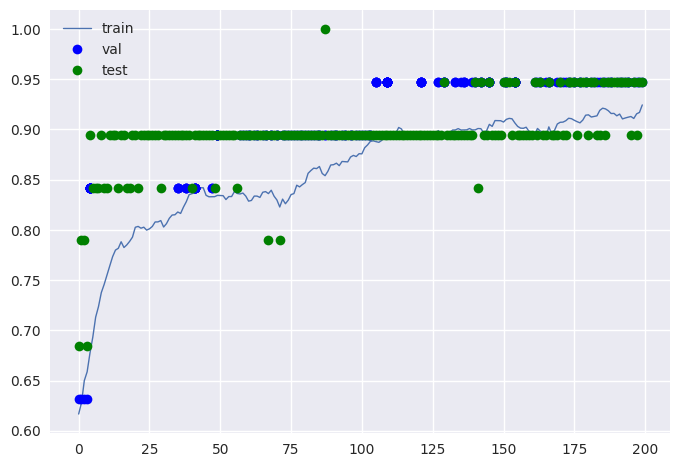

In [126]:
input_dim, hidden_dim, embedding_dim, label_dim, num_layers = 7, 20, 20, 2, 3

same_feat=True
writer=None
mask_nodes=True

model = GcnEncoderGraph(input_dim, hidden_dim, embedding_dim, label_dim, num_layers, args=args)


optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
)
iter = 0
best_val_result = {"epoch": 0, "loss": 0, "acc": 0}
test_result = {"epoch": 0, "loss": 0, "acc": 0}
train_accs = []
train_epochs = []
best_val_accs = []
best_val_epochs = []
test_accs = []
test_epochs = []
val_accs = []

for epoch in range(args.num_epochs):
    begin_time = time.time()
    avg_loss = 0.0
    model.train()
    predictions = []
    print("Epoch: ", epoch)
    for batch_idx, data in enumerate(train_dataset):
        model.zero_grad()
        if batch_idx == 0:
            prev_adjs = data["adj"]
            prev_feats = data["feats"]
            prev_labels = data["label"]
            all_adjs = prev_adjs
            all_feats = prev_feats
            all_labels = prev_labels
        elif batch_idx < 20:
            prev_adjs = data["adj"]
            prev_feats = data["feats"]
            prev_labels = data["label"]
            all_adjs = torch.cat((all_adjs, prev_adjs), dim=0)
            all_feats = torch.cat((all_feats, prev_feats), dim=0)
            all_labels = torch.cat((all_labels, prev_labels), dim=0)
            
        if args.gpu:
            adj = Variable(data["adj"].float(), requires_grad=False).cuda()
            h0 = Variable(data["feats"].float(), requires_grad=False).cuda()
            label = Variable(data["label"].long()).cuda()
            batch_num_nodes = data["num_nodes"].int().numpy() if mask_nodes else None
            assign_input = Variable(
                data["assign_feats"].float(), requires_grad=False
            ).cuda()
            
        else:
            adj = Variable(data["adj"].float(), requires_grad=False)
            h0 = Variable(data["feats"].float(), requires_grad=False)
            label = Variable(data["label"].long())
            batch_num_nodes = data["num_nodes"].int().numpy() if mask_nodes else None
            assign_input = Variable(
                data["assign_feats"].float(), requires_grad=False
            )

        edge_index = []
        for a in adj:
            edge_index.append(from_adj_to_edge_index(a))
        
        ypred = model(h0, edge_index, batch_num_nodes, assign_x=assign_input)
        #ypred, att_adj = model(h0, adj, batch_num_nodes, assign_x=assign_input)
        if batch_idx < 5:
            predictions += ypred.cpu().detach().numpy().tolist()

        if not args.method == "soft-assign" or not args.linkpred:
            loss = model.loss(ypred, label)
        else:
            loss = model.loss(ypred, label, adj, batch_num_nodes)
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), args.clip)
        optimizer.step()
        iter += 1
        avg_loss += loss

    avg_loss /= batch_idx + 1
    elapsed = time.time() - begin_time
    print("Avg loss: ", avg_loss, "; epoch time: ", elapsed)
    
    result = evaluate(train_dataset, model, args, name="Train", max_num_examples=100)
    train_accs.append(result["acc"])
    train_epochs.append(epoch)
    if val_dataset is not None:
        val_result = evaluate(val_dataset, model, args, name="Validation")
        val_accs.append(val_result["acc"])
    if val_result["acc"] > best_val_result["acc"] - 1e-7:
        best_val_result["acc"] = val_result["acc"]
        best_val_result["epoch"] = epoch
        best_val_result["loss"] = avg_loss
    if test_dataset is not None:
        test_result = evaluate(test_dataset, model, args, name="Test")
        test_result["epoch"] = epoch
    print("Best val result: ", best_val_result)
    best_val_epochs.append(best_val_result["epoch"])
    best_val_accs.append(best_val_result["acc"])
    if test_dataset is not None:
        print("Test result: ", test_result)
        test_epochs.append(test_result["epoch"])
        test_accs.append(test_result["acc"])

matplotlib.style.use("seaborn")
plt.switch_backend("agg")
plt.figure()
plt.plot(train_epochs, math_utils.exp_moving_avg(train_accs, 0.85), "-", lw=1)
if test_dataset is not None:
    plt.plot(best_val_epochs, best_val_accs, "bo", test_epochs, test_accs, "go")
    plt.legend(["train", "val", "test"])
else:
    plt.plot(best_val_epochs, best_val_accs, "bo")
    plt.legend(["train", "val"])
#plt.savefig(io_utils.gen_train_plt_name(args), dpi=600)
#plt.close()
matplotlib.style.use("default")

print(all_adjs.shape, all_feats.shape, all_labels.shape)


torch.Size([150, 28, 28]) torch.Size([150, 28, 7]) torch.Size([150])


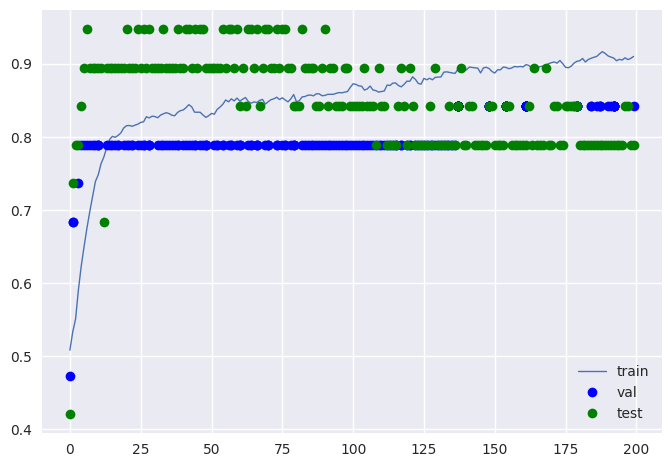

In [107]:
matplotlib.style.use("seaborn")
plt.switch_backend("agg")
plt.figure()
plt.plot(train_epochs, math_utils.exp_moving_avg(train_accs, 0.85), "-", lw=1)
if test_dataset is not None:
    plt.plot(best_val_epochs, best_val_accs, "bo", test_epochs, test_accs, "go")
    plt.legend(["train", "val", "test"])
else:
    plt.plot(best_val_epochs, best_val_accs, "bo")
    plt.legend(["train", "val"])
#plt.savefig(io_utils.gen_train_plt_name(args), dpi=600)
#plt.close()
matplotlib.style.use("default")

print(all_adjs.shape, all_feats.shape, all_labels.shape)


In [127]:
res = evaluate(train_dataset, model, args, name="Train", max_num_examples=100)
res

Train  accuracy: 0.9416666666666667


{'prec': 0.9368471035137702, 'recall': 0.93125, 'acc': 0.9416666666666667}

In [128]:
res = evaluate(test_dataset, model, args, name="Test", max_num_examples=100)
res

Test  accuracy: 0.9473684210526315


{'prec': 0.9642857142857143,
 'recall': 0.9166666666666667,
 'acc': 0.9473684210526315}

### GNNExplainer

In [132]:
import torch
from torch_geometric.nn import GNNExplainer
from tqdm import tqdm
from scipy.special import softmax

EPS = 1e-15


class TargetedGNNExplainer(GNNExplainer):
    def __loss__(self, node_idx, log_logits, target_class):
        loss = -log_logits[node_idx, target_class]

        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()


        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()


        return loss


    def explain_graph_with_target(self, x, edge_index, target, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for a graph.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        # all nodes belong to same graph
        batch = torch.zeros(x.shape[0], dtype=int, device=x.device)

        # Get the initial prediction.
        if target is not None:
            with torch.no_grad():
                out = self.model(x=x, edge_index=edge_index, batch=batch, **kwargs)
                if self.return_type == 'regression':
                    prediction = out
                else:
                    log_logits = self.__to_log_prob__(out)
                    pred_label = log_logits.argmax(dim=-1)
        else:
            if self.return_type == 'regression':
                prediction = target
            else:
                pred_label = target
            

        self.__set_masks__(x, edge_index)
        self.to(x.device)
        if self.allow_edge_mask:
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description('Explain graph')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, batch=batch, **kwargs)
            if self.return_type == 'regression':
                loss = self.__loss__(-1, out, prediction)
            else:
                log_logits = self.__to_log_prob__(out)
                loss = self.__loss__(-1, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid().squeeze()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()
        return edge_mask#node_feat_mask, edge_mask

    
    def explain_node_with_target(self, node_idx, x, edge_index, target, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.__subgraph__(node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        # Get the initial prediction.
        if target is None:
            with torch.no_grad():
                out = self.model(x, edge_index)
                if self.return_type == 'regression':
                    prediction = out
                else:
                    log_logits = self.__to_log_prob__(out)
                    pred_label = log_logits.argmax(dim=-1)
        else:
            if self.return_type == 'regression':
                prediction = target
            else:
                pred_label = target

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            parameters = [self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, 800):#self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x, edge_index)
            if self.return_type == 'regression':
                loss = self.__loss__(mapping, out, prediction)
            else:
                log_logits = self.__to_log_prob__(out)
                loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()


        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()


        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        #return node_feat_mask, edge_mask
        return edge_mask



In [136]:
def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):
    explainer = TargetedGNNExplainer(model, num_hops=3)
    if node_idx is not None:
        edge_mask = explainer.explain_graph_with_target(x=x, edge_index=edge_index, target=target)
    edge_mask = edge_mask.detach().numpy()
    return edge_mask

#from torch_geometric.nn.models import GNNExplainer

"""def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):
    explainer = GNNExplainer(model, num_hops=3)
    if node_idx is not None:
        _, edge_mask = explainer.explain_node(node_idx, x=x, edge_index=edge_index)#, target=target)
    edge_mask = edge_mask.detach().numpy()
    return edge_mask"""

'def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):\n    explainer = GNNExplainer(model, num_hops=3)\n    if node_idx is not None:\n        _, edge_mask = explainer.explain_node(node_idx, x=x, edge_index=edge_index)#, target=target)\n    edge_mask = edge_mask.detach().numpy()\n    return edge_mask'

In [137]:
from torch_geometric.nn import GNNExplainer
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

edge_masks = []

labels = []
preds = []
for batch_idx, data in enumerate(test_dataset):
    if args.gpu:
        adj = Variable(data["adj"].float(), requires_grad=False).cuda()
        h0 = Variable(data["feats"].float()).cuda()
        targets = data["label"].long().numpy()
        labels.append(data["label"].long().numpy())
        batch_num_nodes = data["num_nodes"].int().numpy()
        assign_input = Variable(
            data["assign_feats"].float(), requires_grad=False
        ).cuda()
    else:
        adj = Variable(data["adj"].float(), requires_grad=False)
        h0 = Variable(data["feats"].float())
        targets = data["label"].long().numpy()
        labels.append(data["label"].long().numpy())
        batch_num_nodes = data["num_nodes"].int().numpy()
        assign_input = Variable(
            data["assign_feats"].float(), requires_grad=False
        )

    edge_index = []
    for a in adj:
        edge_index.append(from_adj_to_edge_index(a))
        
    for i in range(len(edge_index)):   
        edge_mask = explain_gnnexplainer(model, -1, h0[i], edge_index[i], targets[i], device, args)
        edge_masks.append(edge_mask)
    
    ypred = model(h0, edge_index, batch_num_nodes, assign_x=assign_input)
    _, indices = torch.max(ypred, 1)
    preds.append(indices.cpu().data.numpy())

"""    if max_num_examples is not None:
        if (batch_idx + 1) * args.batch_size > max_num_examples:
            break"""
            
    



  0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:   0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:  32%|███▏      | 32/100 [00:00<00:00, 314.33it/s]

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 367.82it/s][A


  0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:   0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:  42%|████▏     | 42/100 [00:00<00:00, 410.75it/s]

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 407.69it/s][A


  0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:   0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:  41%|████      | 41/100 [00:00<00:00, 406.13it/s]

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 398.90it/s][A


  0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:   0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:  42%|████▏     | 42/100 [00:00<00:00, 414.61it/s]

Explain graph: 100%|██████████| 100/100 [00:00<00:00, 404.72it/s][A


  0%|          | 0/100 [00:00<?, ?it/s]

Explain graph:   0%|     

'    if max_num_examples is not None:\n        if (batch_idx + 1) * args.batch_size > max_num_examples:\n            break'

In [ ]:
### GNNExplainer

from scipy.special import softmax

def gnn_model(model, x, edge_index):
    h = x.expand(1,-1,-1) #* self.node_feat_mask.sigmoid()
    max_n = x.size(0)
    edge_index = edge_index.expand(1,-1,-1)
    ypred = model(h, edge_index)
    ypred = np.squeeze(ypred.detach().numpy(), axis=0)
    yprob = softmax(ypred, axis = 1)
    ylabels = np.argmax(ypred, 1)
    return ypred, yprob, ylabels

import torch
from torch_geometric.nn import GNNExplainer
from tqdm import tqdm
from scipy.special import softmax

EPS = 1e-15


class TargetedGNNExplainer(GNNExplainer):
    def __loss__(self, node_idx, log_logits, target_class):
        loss = -log_logits[node_idx, target_class]

        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()


        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()


        return loss

    def explain_node_with_target(self, node_idx, x, edge_index, target, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.__subgraph__(node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        # Get the initial prediction.
        if target is None:
            with torch.no_grad():
                out = self.model(x, edge_index)
                if self.return_type == 'regression':
                    prediction = out
                else:
                    log_logits = self.__to_log_prob__(out)
                    pred_label = log_logits.argmax(dim=-1)
        else:
            if self.return_type == 'regression':
                prediction = target
            else:
                pred_label = target

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            parameters = [self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, 800):#self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x, edge_index)
            if self.return_type == 'regression':
                loss = self.__loss__(mapping, out, prediction)
            else:
                log_logits = self.__to_log_prob__(out)
                loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()


        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()


        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        #return node_feat_mask, edge_mask
        return edge_mask



def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):
    explainer = TargetedGNNExplainer(model, num_hops=3)
    if node_idx is not None:
        edge_mask = explainer.explain_node_with_target(node_idx, x=x, edge_index=edge_index, target=target)
    edge_mask = edge_mask.detach().numpy()
    return edge_mask

#from torch_geometric.nn.models import GNNExplainer

"""def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):
    explainer = GNNExplainer(model, num_hops=3)
    if node_idx is not None:
        _, edge_mask = explainer.explain_node(node_idx, x=x, edge_index=edge_index)#, target=target)
    edge_mask = edge_mask.detach().numpy()
    return edge_mask"""

model.eval()

from torch_geometric.nn import GNNExplainer
import random

edge_masks = []

for node_idx in list_test_nodes:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_gnnexplainer(model, node_idx, x_c, edge_index_c, target, device, args)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])
    